In [4]:
# Add PyDatAnalysis to path
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/owensheekey/Documents/Research/PyDatAnalysis")

export_path = 'Exports/'

In [81]:
from __future__ import annotations
from progressbar import progressbar
from src.DatObject.Make_Dat import get_dat, get_dats
import src.UsefulFunctions as U
from src.DataStandardize.ExpSpecific.Feb21 import Feb21Exp2HDF, Feb21ExpConfig
from src.DataStandardize.ExpConfig import ExpConfigGroupDatAttribute, ExpConfigBase
import multiprocessing as mp
import plotly.graph_objs as go
import numpy as np
import lmfit as lm
from typing import TYPE_CHECKING, Iterable, Optional
from src.DatObject.Attributes.Transition import i_sense_digamma, i_sense, i_sense_digamma_quad
from src.UsefulFunctions import edit_params
from src.DatObject.Attributes.SquareEntropy import square_wave_time_array, integrate_entropy
import logging
logger = logging.getLogger(__name__)
import src.UsefulFunctions as U
import scipy.io
from scipy.interpolate import RectBivariateSpline

In [6]:
NRG = scipy.io.loadmat('Results.mat')

In [5]:
def narrow_fit(out, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    x = np.copy(out.x)
    y = np.copy(out.averaged)
    y = np.mean(y[(0, 2), :], axis=0)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [7]:
def narrow_fit_trans_only(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    x = np.copy(dat.Transition.avg_x)
    y = np.copy(dat.Transition.avg_data)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [6]:
def do_calc(datnum, overwrite=True):
    """Just a function which can be passed to a process pool for faster calculation"""
    save_name = 'SPS.005'

    dat = get_dat(datnum)

    setpoints = [0.005, None]

    # Get other inputs
    setpoint_times = square_wave_time_array(dat.SquareEntropy.square_awg)
    sp_start, sp_fin = [U.get_data_index(setpoint_times, sp) for sp in setpoints]
    logger.debug(f'Setpoint times: {setpoints}, Setpoint indexs: {sp_start, sp_fin}')

    # Run Fits
    pp = dat.SquareEntropy.get_ProcessParams(name=None,  # Load default and modify from there
                                             setpoint_start=sp_start, setpoint_fin=sp_fin,
                                             transition_fit_func=i_sense,
                                             save_name=save_name)
    out = dat.SquareEntropy.get_Outputs(name=save_name, inputs=None, process_params=pp, overwrite=overwrite)
    dat.Entropy.get_fit(which='avg', name=save_name, data=out.average_entropy_signal, x=out.x, check_exists=False,
                        overwrite=overwrite)
    [dat.Entropy.get_fit(which='row', row=i, name=save_name,
                         data=row, x=out.x, check_exists=False,
                         overwrite=overwrite) for i, row in enumerate(out.entropy_signal)]
    return out

In [8]:
def get_deltaT(dat):
    """Returns deltaT of a given dat in mV"""
    ho1 = dat.AWG.max(0)  # 'HO1/10M' gives nA * 10
    t = dat.Logs.temps.mc

    # Datnums to search through (only thing that should be changed)
    datnums = set(range(1312, 1451+1)) - set(range(1312, 1451+1, 4))
    # datnums = set()
    # for j in range(5):
    #     datnums = datnums.union(set(range(28 * j + 1312, 28 * j + 1312 + 4 * 7 + 1)) - set([28 * j + 1312 + 4 * i for i in range(8)]))
    # datnums = list(datnums)

    dats = get_dats(datnums)

    dats = [d for d in dats if np.isclose(d.Logs.temps.mc, dat.Logs.temps.mc, rtol=0.1)]  # Get all dats where MC temp is within 10%
    bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])

    indp = np.argmin(abs(bias_lookup - ho1))
    indm = np.argmin(abs(bias_lookup + ho1))
    theta_z = np.nanmean([d.Transition.avg_fit.best_values.theta for d in dats if d.Logs.fds['HO1/10M'] == 0])

    # temp_lookup = np.array([d.Logs.temps.mc for d in dats])
    # bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])
    #
    # indp = np.argmin(temp_lookup - t + bias_lookup - ho1)
    # indm = np.argmin(temp_lookup - t + bias_lookup + ho1)
    # indz = np.argmin(temp_lookup - t + bias_lookup)

    theta_p = dats[indp].Transition.avg_fit.best_values.theta
    theta_m = dats[indm].Transition.avg_fit.best_values.theta
    # theta_z = dats[indz].Transition.avg_fit.best_values.theta
    return (theta_p + theta_m) / 2 - theta_z

In [7]:
def i_sense_digamma(x, mid, g, theta, amp, lin, const):
    from scipy.special import digamma  # FIXME: This is a temporary fix because I run fit code to initialize FitInfo
    arg = digamma(0.5 + (x - mid + 1j * g) / (2 * np.pi * 1j * theta))  # j is imaginary i
    return amp * (0.5 + np.imag(arg) / np.pi) + lin * (
                x - mid) + const - amp / 2  # -amp/2 so const term coincides with i_sense


In [67]:
import lmfit as lm
Ens = np.reshape(NRG['Ens'], 401)
Ts = np.reshape(NRG['Ts'], 70)

In [68]:
dmodel = lm.Model(i_sense_digamma)
_pars = lm.Parameters()
_pars.add_many(
    ('mid', 0, True, None, None, None, None),
    ('theta', 1, True, None, None, None, None),
    ('amp', 1, False, None, None, None, None),
    ('lin', 0, False, None, None, None, None),
    ('const', 0, True, None, None, None, None),
    ('g', 0.001, True, None, None, None, None))

In [74]:
fig = go.Figure()
results = []
for i, t in progressbar(enumerate(Ts)):
    result = dmodel.fit(NRG["Occupation_mat"][:, i], _pars, x=Ens)
    fig.add_trace(go.Scatter(mode='markers',x=Ens, y=NRG["Occupation_mat"][:, i], name=f'NRG: {0.001/t:.4f}'))
    fig.add_trace(go.Scatter(mode='lines',x=Ens, y=result.eval(x=Ens), name=f'Digamma: {0.001/t:.4f}', marker_color='grey'))
    results.append(result)

    
fig.update_layout(xaxis_title='Energy /arb', yaxis_title='Occupation',
                      title=f'Digamma fit of NRG data')
fig.show(renderer="browser")

| |                                                 #| 69 Elapsed Time: 0:00:14


In [73]:
fig.write_html(f'Exports/DigammaNRG_All.html') 

In [122]:
# Where the model lives on x = [0,1]
# Simple linear interpolation between values
occ = NRG["Occupation_mat"]
ens = np.reshape(NRG["Ens"], 401)
ts  = np.reshape(NRG["Ts"], 70)
ens = np.flip(ens)
occ = np.flip(occ, 0)
interp = RectBivariateSpline(ens, np.log10(ts), occ, kx=1,ky=1)
def interpNRG(x, dx, amp, center, lin, const, logt):
    ens = x*dx+center
    val = [interp(en, logt)[0][0] for en in ens]
    val += const + lin*x
    return val

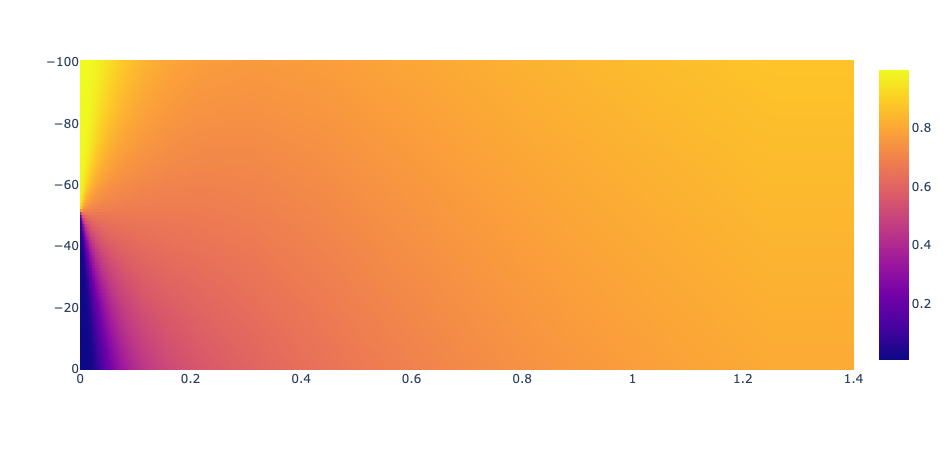

In [116]:
''' Won't run again, but nice for reference '''
# new_data = [[interpNRG(en, 1, 1, 0, 0, 0, np.log10(t)) for t in np.linspace(0.0001,1.4,1000)] for en in np.linspace(-0.1, 0.1, 100)]
# import plotly.express as px
# fig = px.imshow(new_data,x=np.linspace(0.0001,1.4,1000), y=np.linspace(-100, 0.1, 100), aspect="auto")
# fig.show()

In [123]:
nrgmodel = lm.Model(interpNRG)
nrg_pars = lm.Parameters()
nrg_pars.add_many(
    ('dx', 0, True, None, None, None, None),
    ('amp', 1, True, None, None, None, None),
    ('center', 1, True, None, None, None, None),
    ('lin', 0, True, None, None, None, None),
    ('const', 0, True, None, None, None, None),
    ('logt', 0.01, False, 1e-7, None, None, None))

In [124]:
fig = go.Figure()
results = []
for i, t in progressbar(enumerate(Ts)):
    result = nrgmodel.fit(NRG["Occupation_mat"][:, i], nrg_pars, x=Ens)
    fig.add_trace(go.Scatter(mode='markers',x=Ens, y=NRG["Occupation_mat"][:, i], name=f'NRG: {0.001/t:.4f}'))
    fig.add_trace(go.Scatter(mode='lines',x=Ens, y=result.eval(x=Ens), name=f'Digamma: {0.001/t:.4f}', marker_color='grey'))
    results.append(result)

    
fig.update_layout(xaxis_title='Energy /arb', yaxis_title='Occupation',
                      title=f'Digamma fit of NRG data')
fig.show(renderer="browser")

| |                         #                        | 69 Elapsed Time: 0:00:02
